<a href="https://colab.research.google.com/github/junieberry/DL-fromScratch2/blob/main/06_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
cd /content/drive/MyDrive/밑시딥/deep-learning-from-scratch-2

/content/drive/MyDrive/밑시딥/deep-learning-from-scratch-2


In [3]:
import sys
sys.path.append('..')
from common.util import preprocess
import numpy as np

## LSTM

In [4]:
from common.functions import sigmoid

class LSTM:

  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    # forward 때 저장했다가 backward에 사용
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape

    # Affine 변환
    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

    # slice
    f = sigmoid(A[:, :H])
    g = tanh(A[:, H:2*H])
    i = sigmoid(A[:, 2*H:3*H])
    o = sigmoid(A[:, 3*H:])

    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x. h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

## Time LSTM

In [5]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeors_like(Wh), np.zeros_like(b)]
    self.layers = None
    self.h, self.c = None, None
    self.stateful = stateful

  def forward(self, xs):

    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N,H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')
    
    for t in range(T):
      layer = LSTM(*self.params)
      self.h, self.c = layer.forward(xs[:,t,:], self.h, self.c)
      hs[:,t,:] = self.h

      self.layers.append(layer)

    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D),dtype='f')
    dh, dc = 0,0

    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc)
      dxs[:,t,:] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
    
    for i,grad in enumerate(grads):
      self.grads[i][...] = grad
      self.dh = dh
      return dxs
  
  def set_state(self, h, c=None):
    self.h, self.c = h,c
  
  def reset_state(self):
    self.h, self.c = None, None

## Rnnlm

In [6]:
from common.time_layers import *
import pickle

class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # initialize weight
    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

    self.params, self.grads = [],[]
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, xs):
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self,dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()
  
  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
      pickle.dump(self.params, f)
  
  def load_params(self, file_name = 'Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
      self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10000.85
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2675.37
| 에폭 1 |  반복 41 / 1327 | 시간 12[s] | 퍼플렉서티 1282.86
| 에폭 1 |  반복 61 / 1327 | 시간 18[s] | 퍼플렉서티 976.42
| 에폭 1 |  반복 81 / 1327 | 시간 24[s] | 퍼플렉서티 770.27
| 에폭 1 |  반복 101 / 1327 | 시간 30[s] | 퍼플렉서티 676.24
| 에폭 1 |  반복 121 / 1327 | 시간 36[s] | 퍼플렉서티 658.40
| 에폭 1 |  반복 141 / 1327 | 시간 42[s] | 퍼플렉서티 577.16
| 에폭 1 |  반복 161 / 1327 | 시간 48[s] | 퍼플렉서티 562.41
| 에폭 1 |  반복 181 / 1327 | 시간 54[s] | 퍼플렉서티 577.66
| 에폭 1 |  반복 201 / 1327 | 시간 60[s] | 퍼플렉서티 503.24
| 에폭 1 |  반복 221 / 1327 | 시간 66[s] | 퍼플렉서티 485.36
| 에폭 1 |  반복 241 / 1327 | 시간 73[s] | 퍼플렉서티 437.19
| 에폭 1 |  반복 261 / 1327 | 시간 79[s] | 퍼플렉서티 460.37
| 에폭 1 |  반복 281 / 1327 | 시간 85[s] | 퍼플렉서티 450.94
| 에폭 1 |  반복 301 / 1327 | 시간 91[s] | 퍼플렉서티 393.97
| 에폭 1 |  반복 321 / 1327 | 시간 97[s] | 퍼플렉서티 339.39
| 에폭 1 |  반복 341 / 1327 | 시간 103[s] | 퍼플렉서티 403.30
| 에폭 1 |  반복 361 / 1327 | 시간 109[s] | 퍼플렉서티 402.47
| 에폭 1 |  반복 381 / 1327 | 시간 115[s] | 퍼플렉서티 338.57
|

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_

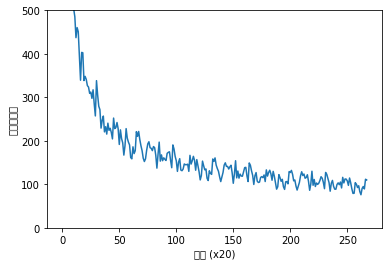

퍼플렉서티 평가 중 ...
234 / 235


In [7]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

## 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ =ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

## 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

##기울기 클리핑까지
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)

model.save_params()

## Improved LSTM

In [16]:
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
  def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    # initialize weight
    embed_W = (rn(V, D)/100).astype('f')
    lstm_Wx1 = (rn(D, 4*H)/np.sqrt(D)).astype('f')
    lstm_Wh1 = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b1 = np.zeros(4*H).astype('f')
    lstm_Wx2 = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_Wh2 = (rn(H, 4*H)/np.sqrt(H)).astype('f')
    lstm_b2 = np.zeros(4*H).astype('f')
    affine_b = np.zeros(V).astype('f')

    # 계층 생성
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeDropout(dropout_ratio),
                   TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
                   TimeDropout(dropout_ratio),
                   TimeAffine(embed_W.T, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = [self.layers[2], self.layers[4]]
    self.drop_layer = [self.layers[1], self.layers[3], self.layers[5]]

    self.params, self.grads = [],[]
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
  
  def predict(self, xs, train_flg=False):
    for layer in self.drop_layer:
      layer.train_flg = train_flg
    for layer in self.layers:
      xs = layer.forward(xs)
    return xs
  
  def forward(self, xs, ts, train_flg=True):
    score = self.predict(xs, train_flg)
    loss = self.loss_layer.forward(score, ts)
    return loss
  
  def backward(self,dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    for layer in self.lstm_layers:
      layer.reset_state()


In [17]:
from common import config
config.GPU =True
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25
dropout = 0.5

## 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ =ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

## 모델 생성
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size,dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
  trainer.fit(xs, ts, max_epoch,batch_size, time_size, max_grad=max_grad)
  model.reset_state()
  ppl = eval_perplexity(model, corpus_val)
  print('검증 perplexity >>',ppl)

  if best_ppl>ppl:
    best_ppl = ppl
    model.save_params()
  else:
    lr /= 4.0
    optimizer.lr = lr
  
  model.reset_state()
  print("-"*40)

| 에폭 1 |  반복 1 / 1327 | 시간 3[s] | 퍼플렉서티 10000.40
| 에폭 1 |  반복 21 / 1327 | 시간 71[s] | 퍼플렉서티 4211.12
| 에폭 1 |  반복 41 / 1327 | 시간 140[s] | 퍼플렉서티 1792.14
| 에폭 1 |  반복 61 / 1327 | 시간 208[s] | 퍼플렉서티 1250.66


KeyboardInterrupt: ignored